In [96]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from konlpy.tag import Okt
from konlpy.tag import Kkma
from wordcloud import WordCloud
import datetime

In [97]:
# 한글 깨짐 방지

plt.rc('font', family='Malgun Gothic')

## 데이터 분석

In [98]:
education = pd.read_csv("교육청민원.csv")
traffic = pd.read_csv("국토교통부민원.csv")
sea = pd.read_csv("해양수산부민원.csv")
df = pd.concat([education, traffic, sea], axis=0)      # 모든 테이블 합침
complaint = pd.read_csv("민원항목.csv")                # 민원 항목

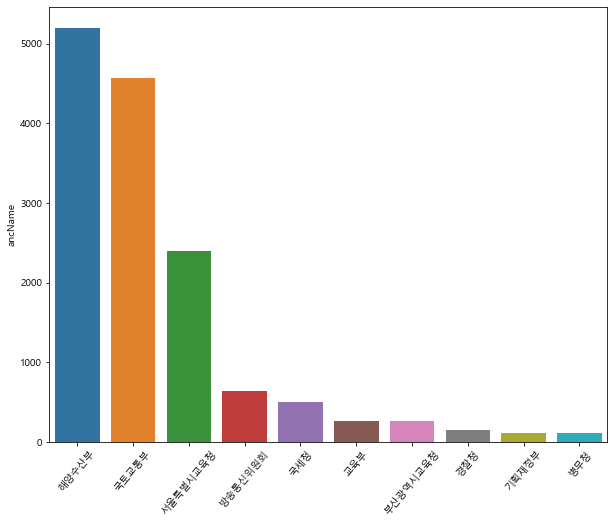

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x = complaint.ancName.value_counts().index[:10], y = df.ancName.value_counts()[:10])
plt.xticks(rotation = 50)
plt.show()

In [100]:
# 필요없는 열 제거

df = df.drop(['faqNo','dutySctnNm','ansCntnCl','deptName', 'deptCode', 'lawList', 'subjList', 'ancCode'],  axis = 1)

In [101]:
df.isna().sum()    # 열별 결측치

qnaTitl       0
qstnCntnCl    0
ancName       0
regDate       0
dtype: int64

In [102]:
df = df.reset_index().drop('index', axis = 1)   # 인덱스 리셋

In [103]:
df.ancName = df.ancName.where(df.ancName.str.contains("교육청") == False, '교육청')    # 여러 지역 교육청을 다 '교육청'으로 바꾸기

In [104]:
df.head()

,qnaTitl,qstnCntnCl,ancName,regDate
0,학교운영위원의 연임후 다시 운영위원이 될 수 있는 시기,당해 학교에서 4년간 운영위원을 하고 1년 후 보궐선출로 다시 당해 학교 운영위원이...,교육청,20210908
1,학교운영위원회 의결사항에 대한 이행 여부,학교운영위원회에서 결정이 내려지면 학교장은 그 심의결과에 꼭 따라야만 하나요?,교육청,20210908
2,학교운영위원회와 학부모회의 차이점,학교운영위원회와 학부모회의 차이점은 무엇인가요?,교육청,20210908
3,학교 형광등 교체,학교 형광등은 언제 LED전등으로 교체되나요?,교육청,20210908
4,누리과정 운영 시간의 탄력적 운영,누리과정 운영 시간이 어떻게 되나요?,교육청,20210908


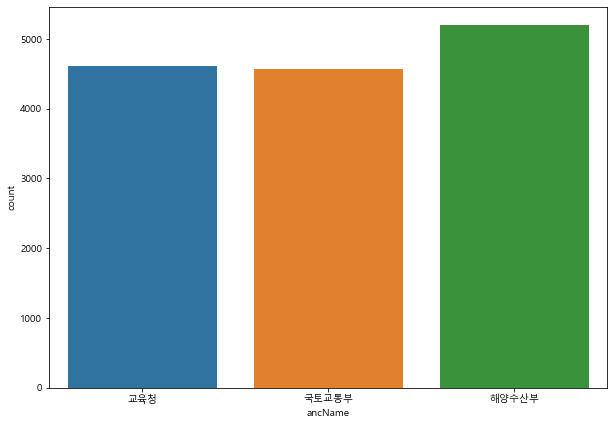

In [105]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = sns.countplot(x="ancName", data=df)    # 부서별 민원 수 막대그래프

# 해양수산부가 조금 많지만 개수가 모두 비슷비슷함

In [106]:
df.regDate = pd.to_datetime(df.regDate, format = "%Y%m%d")    # 민원 신청일을 타임 스템프 형식으로 바꿈

In [107]:
group = df.groupby('regDate')['qnaTitl'].count()              # 신청일별 민원 제목 개수

In [108]:
group[:5]

regDate
2021-01-15     1
2021-01-19     1
2021-01-25     9
2021-02-10    57
2021-02-25     1
Name: qnaTitl, dtype: int64

<AxesSubplot:xlabel='regDate'>

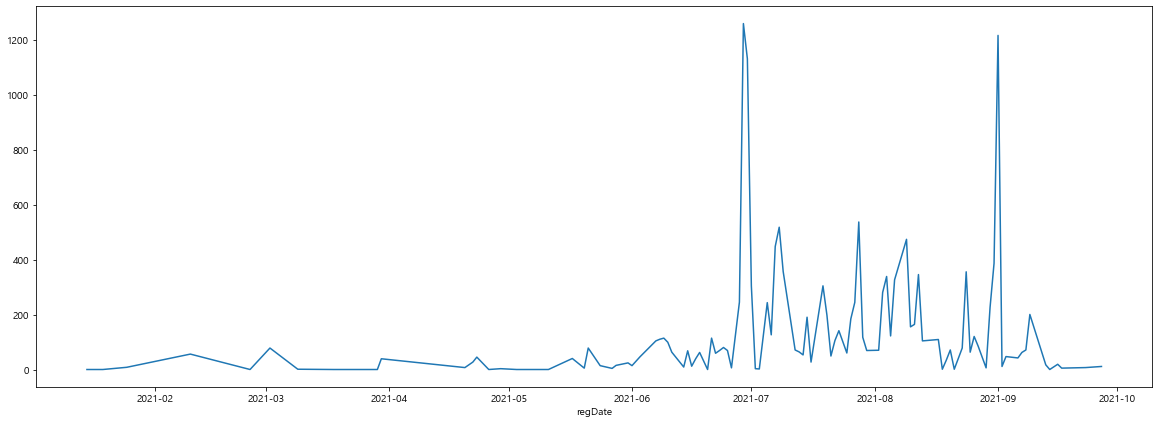

In [109]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.lineplot(x=group.index, y=group.values, data = group)    # 민원 신청일에 따른 시계열 라인 그래프

In [110]:
data = df.groupby(['ancName', 'regDate'])['qnaTitl'].count().reset_index()         # 신청일과 부서별 민원 제목 카운트

In [111]:
data[:5]

,ancName,regDate,qnaTitl
0,교육청,2021-06-07,71
1,교육청,2021-06-08,63
2,교육청,2021-06-09,37
3,교육청,2021-06-10,100
4,교육청,2021-06-11,27


<AxesSubplot:xlabel='regDate', ylabel='qnaTitl'>

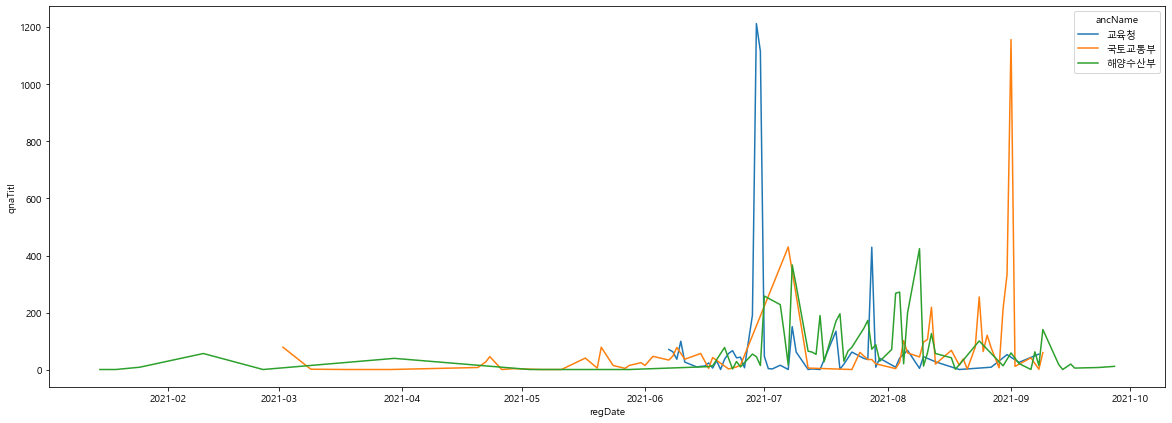

In [112]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.lineplot(x="regDate",
             y="qnaTitl",
             hue="ancName",
             data=data)         # 부서별 민원 수 신청일 라인 그래프

In [113]:
(
  df
 .groupby(['ancName', 'regDate'])['regDate']
 .count()['교육청']
 .sort_values(ascending=False)[0:5]
)

regDate
2021-06-29    1212
2021-06-30    1115
2021-07-28     429
2021-06-28     191
2021-07-08     151
Name: regDate, dtype: int64

In [116]:
e_0630 = df[(df['ancName'] == '교육청') & (pd.to_datetime('2021-06-28') < df['regDate']) & (pd.to_datetime('2021-07-01') > df['regDate'])]
e_0630.head()

,qnaTitl,qstnCntnCl,ancName,regDate
1444,평생교육시설의 불법 영업 신고,원격평생교육시설 제000호로 등록 되어 있다는 000000000 이라는 온라인 교육...,교육청,2021-06-30
1445,독서실 방역수칙 위반 관련,독서실을 이용하는데 방역수칙을 안지켜서 신고하려고합니다. 이제는 마스크미착용으로 개...,교육청,2021-06-30
1446,중고등학교 신설 건,금천구 독산1동은 중고등학교 학군이 부족해서 다리건너 광명쪽으로 등하교를 하고 있는...,교육청,2021-06-30
1447,금천구 중고교 설립,금천구는 서울 서남권의 변두리로 지역발전이 더디고 못사는 동네라고 편견이 강한 지역...,교육청,2021-06-30
1448,금천구 중고교 설립,금천구는 서울 서남권의 변두리로 지역발전이 더디고 못사는 동네라고 편견이 강한 지...,교육청,2021-06-30


In [117]:
(
  df
 .groupby(['ancName', 'regDate'])['regDate']
 .count()['국토교통부']
 .sort_values(ascending=False)[0:5]
)

regDate
2021-09-01    1156
2021-07-07     430
2021-08-31     334
2021-08-24     255
2021-08-12     219
Name: regDate, dtype: int64

In [118]:
t_0901 = df[(df['ancName'] == '국토교통부') & (pd.to_datetime('2021-09-01') == df['regDate'])]
t_0901.head()

,qnaTitl,qstnCntnCl,ancName,regDate
4728,인천공항 출발 및 도착절차를 보고 싶을 땐 어떻게 해야하나요?,인천공항 출발 및 도착절차를 보고 싶을 땐 어떻게 해야하나요?,국토교통부,2021-09-01
4729,항공통신 지명약어의 등록취소는 어떻게 진행되나요?,항공통신 지명약어의 등록취소는 어떻게 진행되나요?,국토교통부,2021-09-01
4730,품질관리(시험)계획 수립대상 공사에는 어떤 것이 있나요?,품질관리(시험)계획 수립대상 공사에는 어떤 것이 있나요?,국토교통부,2021-09-01
4731,레미콘 등 관급자재의 품질관리는?,"레미콘, 아스콘 등 관급자재의 경우 품질관리를 하지 않아도 되는지?",국토교통부,2021-09-01
4732,하천 옆에 도로가 있으면 하천구역은 도로 앞까지 인가요?,하천 옆에 도로가 있으면 하천구역은 도로 앞까지 인가요?,국토교통부,2021-09-01


In [119]:
def func(a, b):              # 민원 제목과 내용을 리스트에 담고 합치는 함수
    Titl = []
    CntnCl = []
    
    for i in a:
        Titl.append(i)
    
    for j in b:
        CntnCl.append(j)

    return Titl + CntnCl

In [120]:
education = func(education['qnaTitl'], education['qstnCntnCl'])   

traffic = func(traffic['qnaTitl'], traffic['qstnCntnCl'])

sea = func(sea['qnaTitl'], sea['qstnCntnCl'])

e_0630 = func(e_0630['qnaTitl'], e_0630['qstnCntnCl'])

t_0901 = func(t_0901['qnaTitl'], t_0901['qstnCntnCl'])

In [121]:
education[:5]

['학교운영위원의 연임후 다시 운영위원이 될 수 있는 시기',
 '학교운영위원회 의결사항에 대한 이행 여부',
 '학교운영위원회와 학부모회의 차이점',
 '학교 형광등 교체',
 '누리과정 운영 시간의 탄력적 운영']

In [122]:
traffic[0:5]

['일반국도를 운행시 도로시설물 등으로 인해 피해를 입은 경우에 대한 보상',
 '국도 도로관리청 문의',
 '연고자 우선매수 가능여부',
 '국유지와 사유지의 교환 가능여부',
 '국토교통부 소관 국유재산의 관리기관에 대한 질의']

In [123]:
sea[:5]

['정보공개 청구시 비용이 어떻게 되는지 궁금합니다',
 '청원경찰 응시자격과 채용방법이 어떻게 되나요?',
 '민원서류 보완 기간을 연장하고 싶습니다.',
 '비어업인의 수산자원 포획, 채취 시 사용가능한 어구 또는 방법과 유의사항',
 '갯녹음이란 무엇인가요']

In [124]:
stopwords = []

url = 'https://www.ranks.nl/stopwords/korean'
raw = requests.get(url, verify = False)

soup = BeautifulSoup(raw.text, 'html.parser')

soup = soup.find_all('td')

for i in soup:
    for j in i:
        if j.string == None:
            continue
        else:
            stopwords.append(j)

stopwords[:5]

C:\Users\ynk99\anaconda3\envs\sunlight\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ranks.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


['아', '휴', '아이구', '아이쿠', '아이고']

In [125]:
# kkma로 하고 싶었지만 속도가 너무 느리고 복잡해서 다루기 어려웠음

okt = Okt()
kkma = Kkma() 

konlpy_test = '안녕하세요. 제 주제는 민원 부서 분류입니다. 자연어 처리 힘드네요... '

okt.morphs(konlpy_test)

['안녕하세요',
 '.',
 '제',
 '주제',
 '는',
 '민원',
 '부서',
 '분류',
 '입니다',
 '.',
 '자연어',
 '처리',
 '힘드네요',
 '...']

In [126]:
kkma.morphs(konlpy_test)

['안녕',
 '하',
 '세요',
 '.',
 '저',
 '의',
 '주제',
 '는',
 '민원',
 '부서',
 '분류',
 '이',
 'ㅂ니다',
 '.',
 '자연어',
 '처리',
 '힘들',
 '네요',
 '...']

In [127]:
def clean(data):
    clean_tokens = []
    for i in data:
        i = re.sub(r'[^ 가-힣]', '', i)                          # 한글 말고 모두 제거
        clean_tokens.append(i)
        
    okt = Okt()
    for i in range(len(clean_tokens)):
        clean_words = []
        for word in okt.morphs(clean_tokens[i]):               # 토큰화
            if (word not in stopwords) and (len(word) > 1):   # 불용어 처리와 길이가 1보다 큰 토큰만 남김
                clean_words.append(word)
            clean_tokens[i] = ' '.join(clean_words)            
    return clean_tokens

def token(data):
    okt = Okt()
    tokens_list = []
    for i in data:
        for j in okt.morphs(i):
            tokens_list.append(j)
    token_df = pd.DataFrame(tokens_list, columns = ['token'])
    return token_df

In [128]:
education_tokens = clean(education)
traffic_tokens = clean(traffic)
sea_tokens = clean(sea)
e_tokens = clean(e_0630)
t_tokens = clean(t_0901)

In [129]:
education_tokens[:5]

['학교 운영 위원 임후 다시 운영 위원 있는 시기',
 '학교 운영 위원회 의결 사항 대한 이행',
 '학교 운영 위원회 학부모 회의 차이점',
 '학교 형광등 교체',
 '누리 과정 운영 탄력 운영']

In [130]:
education_tokens_df = token(education_tokens)
traffic_tokens_df = token(traffic_tokens)
sea_tokens_df = token(sea_tokens)
e_tokens_df = token(e_tokens)
t_tokens_df = token(t_tokens)

In [131]:
education_tokens_df.head()

,token
0,학교
1,운영
2,위원
3,임후
4,다시


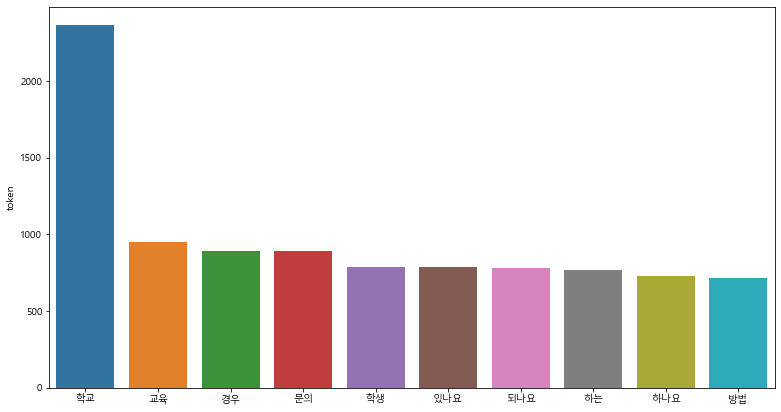

In [132]:
# 교육청 단어 빈도수 막대그래프

fig, ax = plt.subplots(figsize=(13, 7))
top_10_education = education_tokens_df['token'].value_counts()  
sns.barplot(x=top_10_education[0:10].index, y = top_10_education[0:10])

plt.show()

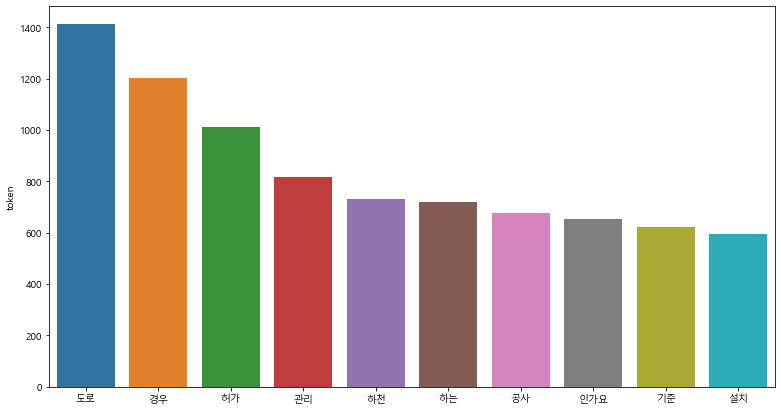

In [133]:
# 국토교통부 단어 빈도수 막대그래프

fig, ax = plt.subplots(figsize=(13, 7))

top_10_traffic = traffic_tokens_df['token'].value_counts()
sns.barplot(x=top_10_traffic[0:10].index, y = top_10_traffic[0:10])

plt.show()

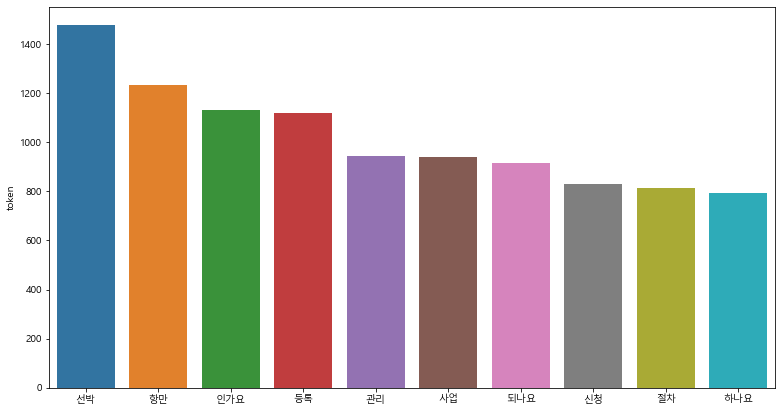

In [134]:
# 해양수산부 단어 빈도수 막대그래프

fig, ax = plt.subplots(figsize=(13, 7))
top_10_sea = sea_tokens_df['token'].value_counts()
sns.barplot(x=top_10_sea[0:10].index, y = top_10_sea[0:10])

plt.show()

In [135]:
tokens = pd.concat([education_tokens_df, traffic_tokens_df, sea_tokens_df], axis = 0)  # 모든 토큰들 합침

In [136]:
tokens.head()

,token
0,학교
1,운영
2,위원
3,임후
4,다시


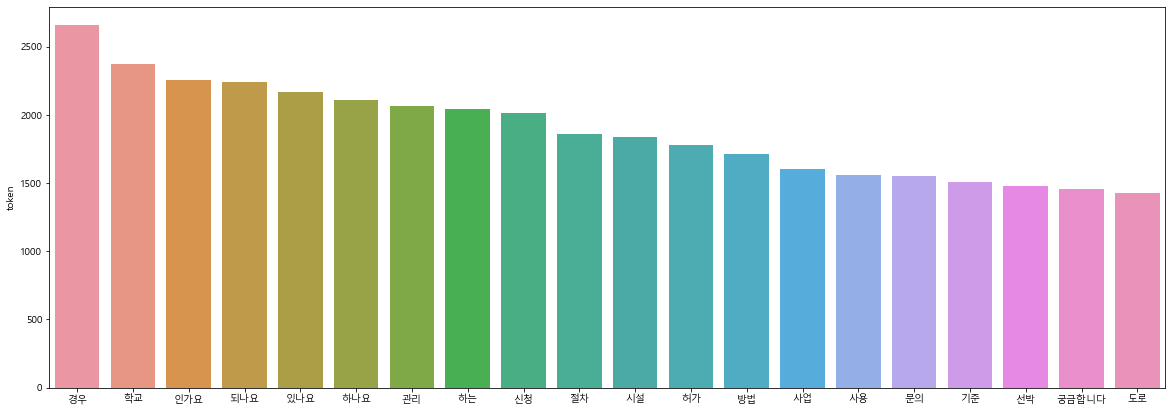

In [137]:
# 모든 민원 단어 빈도수
# 민원에 상관없이 많이 나온 단어는 불용어일 것으로 추측
# 인가요, 되나요 등

fig, ax = plt.subplots(figsize=(20, 7))            
top_10_tokens = tokens['token'].value_counts()
sns.barplot(x=top_10_tokens[0:20].index, y = top_10_tokens[0:20])

plt.show()

In [138]:
stopwords.append('경우')
stopwords.append('인가요')
stopwords.append('되나요')
stopwords.append('있나요')
stopwords.append('하나요')
stopwords.append('하는')
stopwords.append('궁금합니다')

# 불용어 사전으로 걸러내지 못했던 불용어들을 사전에 추가

In [139]:
stopwords[-5:]

['되나요', '있나요', '하나요', '하는', '궁금합니다']

In [140]:
education_tokens = clean(education)
traffic_tokens = clean(traffic)
sea_tokens = clean(sea)
e_tokens = clean(e_0630)
t_tokens = clean(t_0901)

In [141]:
education_tokens_df = token(education_tokens)
traffic_tokens_df = token(traffic_tokens)
sea_tokens_df = token(sea_tokens)
e_tokens_df = token(e_tokens)
t_tokens_df = token(t_tokens)

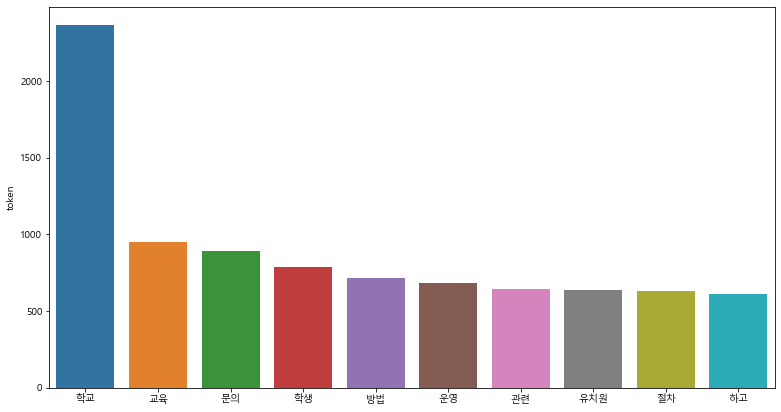

In [142]:
fig, ax = plt.subplots(figsize=(13, 7))
top_10_education = education_tokens_df['token'].value_counts()
sns.barplot(x=top_10_education[0:10].index, y = top_10_education[0:10])

plt.show()

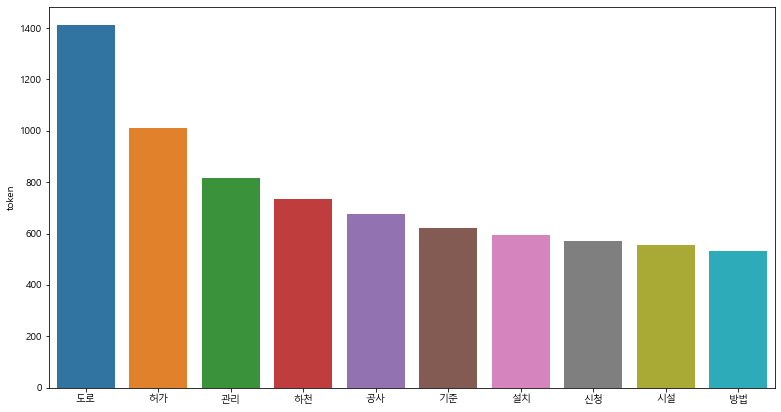

In [143]:
fig, ax = plt.subplots(figsize=(13, 7))
top_10_traffic = traffic_tokens_df['token'].value_counts()
sns.barplot(x=top_10_traffic[0:10].index, y = top_10_traffic[0:10])

plt.show()

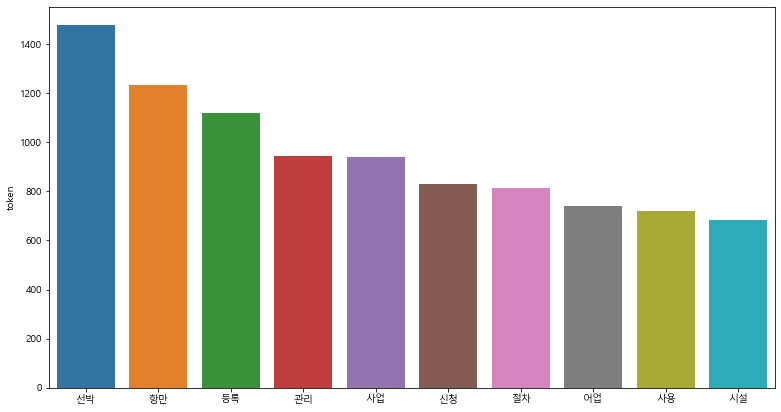

In [144]:
fig, ax = plt.subplots(figsize=(13, 7))
top_10_sea = sea_tokens_df['token'].value_counts()
sns.barplot(x=top_10_sea[0:10].index, y = top_10_sea[0:10])

plt.show()

In [145]:
# 워드클라우드를 그리기 위해 str형으로 바꿔줌

education_str = ' '.join(education_tokens) 
traffic_str = ' '.join(traffic_tokens) 
sea_str = ' '.join(sea_tokens) 
e_0630_str = ' '.join(e_tokens) 
t_0901_str = ' '.join(t_tokens) 

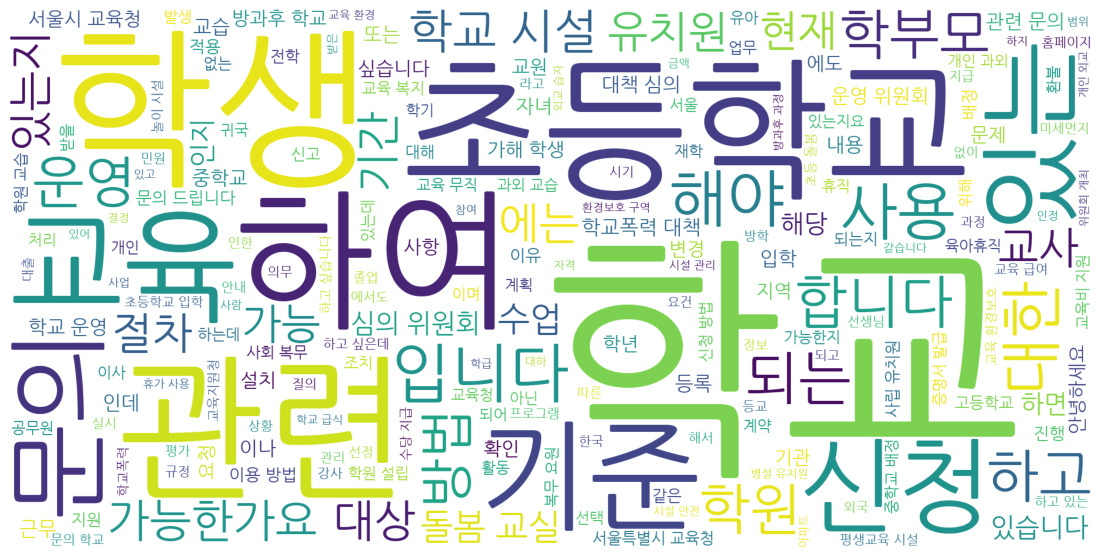

In [146]:
# 6월 29일과 30일 교육청에 무슨 일이 일어났을 것이라고 추측했는데, 전체 교육청 워드클라우드와 별로 다를 것이 없어보임...

wc = WordCloud(font_path='C:/WINDOWS/Fonts/NanumGothic.ttf',
               width=2000,             # 너비
               height=1000,            # 높이
               background_color='white',   #배경 색
               margin=10)               # 여백

wc.generate(e_0630_str)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')       # 축 없앰
plt.show()

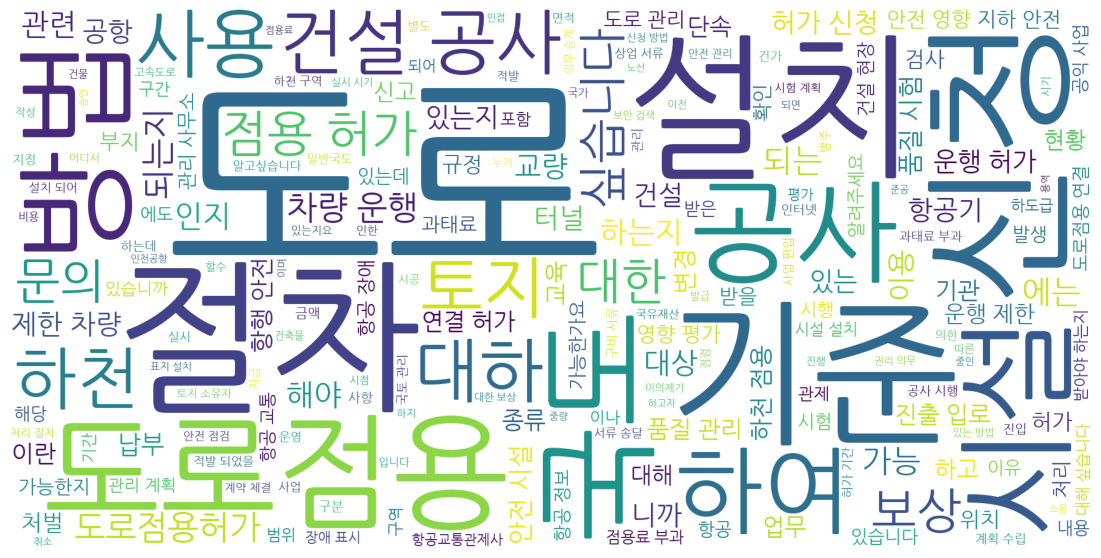

In [147]:
# 9월 1일 국토교통부에 무슨 일이 일어났을 것이라고 추측했는데, 전체 국토교통부 워드클라우드와 별로 다를 것이 없어보임...

wc = WordCloud(font_path='C:/WINDOWS/Fonts/NanumGothic.ttf',
               width=2000,             # 너비
               height=1000,            # 높이
               background_color='white',   #배경 색
               margin=10)               # 여백

wc.generate(t_0901_str)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')       # 축 없앰
plt.show()

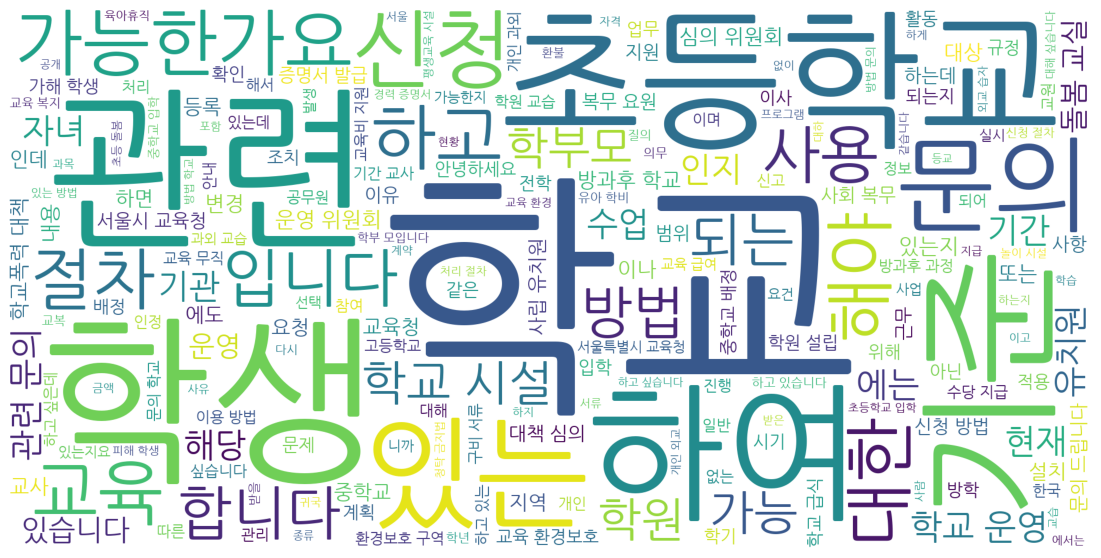

In [53]:
wc = WordCloud(font_path='C:/WINDOWS/Fonts/NanumGothic.ttf',
               width=2000,             # 너비
               height=1000,            # 높이
               background_color='white',   #배경 색
               margin=10)               # 여백

wc.generate(education_str)            # 전체 교육청 워드클라우드

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')       # 축 없앰
plt.show()

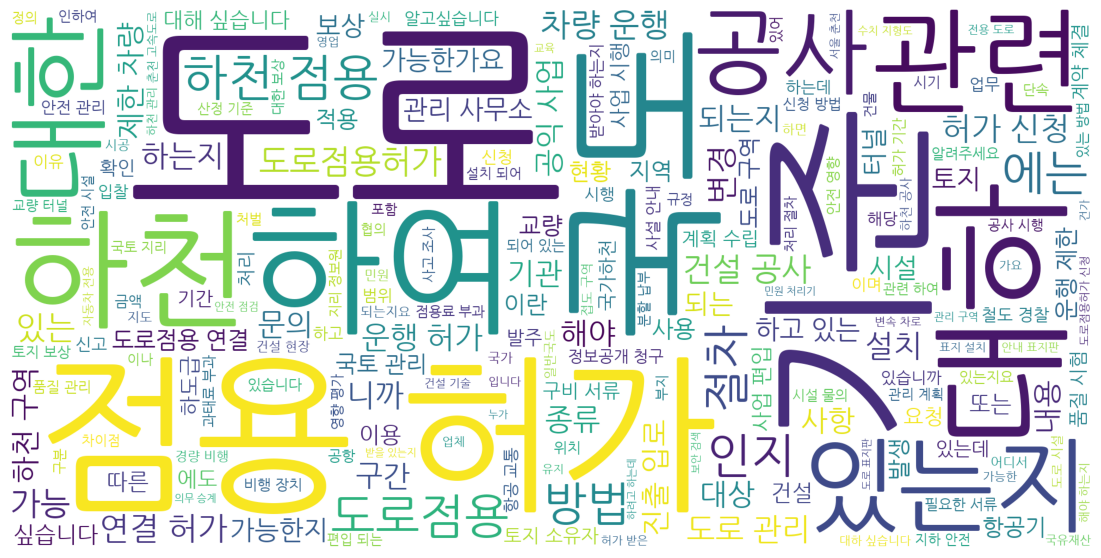

In [54]:
wc = WordCloud(font_path='C:/WINDOWS/Fonts/NanumGothic.ttf',
               width=2000,             # 너비
               height=1000,            # 높이
               background_color='white',   #배경 색
               margin=10)               # 여백

wc.generate(traffic_str)               # 전체 국토교통부 워드클라우드

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')       # 축 없앰
plt.show()

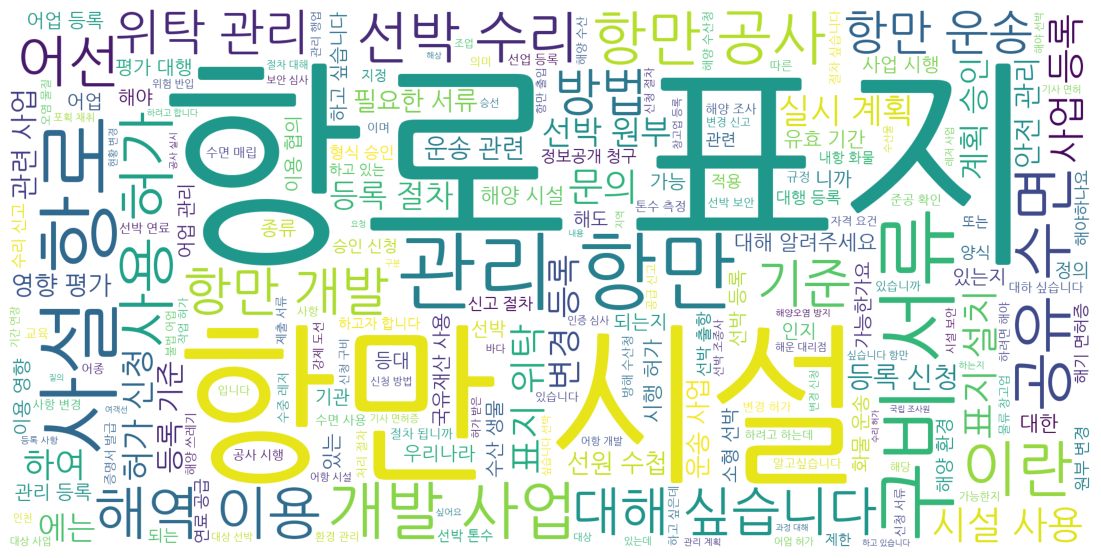

In [55]:
wc = WordCloud(font_path='C:/WINDOWS/Fonts/NanumGothic.ttf',
               width=2000,             # 너비
               height=1000,            # 높이
               background_color='white',   #배경 색
               margin=10)               # 여백

wc.generate(sea_str)                     # 전체 해양수산부 워드클라우드

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')       # 축 없앰
plt.show()